Abstract: This is a difficult regression task, where **the aim is to predict the burned area of forest fires, in the northeast region of Portugal**, by using meteorological and other data.

**Source:**

Paulo Cortez, pcortez '@' dsi.uminho.pt, Department of Information Systems, University of Minho, Portugal.
Aníbal Morais, araimorais '@' gmail.com, Department of Information Systems, University of Minho, Portugal.

**Citation Request:**

This dataset is public available for research. The details are described in [Cortez and Morais, 2007].   
Please include this citation if you plan to use this database:   
[Cortez and Morais, 2007] P. Cortez and A. Morais. A Data Mining Approach to Predict Forest Fires using Meteorological Data. In J. Neves, M. F. Santos and J. Machado Eds., New Trends in Artificial Intelligence, Proceedings of the 13th EPIA 2007 - Portuguese Conference on Artificial Intelligence, December, Guimarães, Portugal, pp. 512-523, 2007. APPIA, ISBN-13 978-989-95618-0-9. Available at: [Web Link]

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import seaborn as sns
%matplotlib inline

In [3]:
df = pd.read_csv('forestfires.csv')

In [4]:
df.columns = df.columns.str.lower()
df.head()

,x,y,month,day,ffmc,dmc,dc,isi,temp,rh,wind,rain,area
0,7,5,mar,fri,86.2,26.2,94.3,5.1,8.2,51,6.7,0.0,0.0
1,7,4,oct,tue,90.6,35.4,669.1,6.7,18.0,33,0.9,0.0,0.0
2,7,4,oct,sat,90.6,43.7,686.9,6.7,14.6,33,1.3,0.0,0.0
3,8,6,mar,fri,91.7,33.3,77.5,9.0,8.3,97,4.0,0.2,0.0
4,8,6,mar,sun,89.3,51.3,102.2,9.6,11.4,99,1.8,0.0,0.0


<BarContainer object of 517 artists>

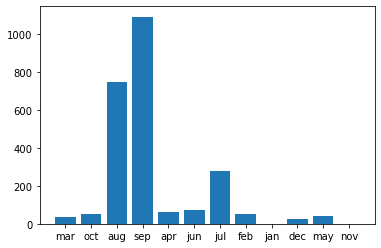

In [5]:
plt.bar(df.month, df.area) #Some basic plots

<BarContainer object of 517 artists>

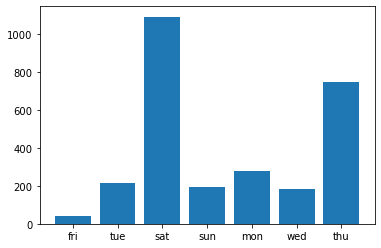

In [6]:
plt.bar(df.day, df.area)

(array([508.,   6.,   1.,   0.,   0.,   0.,   1.,   0.,   0.,   1.]),
 array([   0.   ,  109.084,  218.168,  327.252,  436.336,  545.42 ,
         654.504,  763.588,  872.672,  981.756, 1090.84 ]),
 <BarContainer object of 10 artists>)

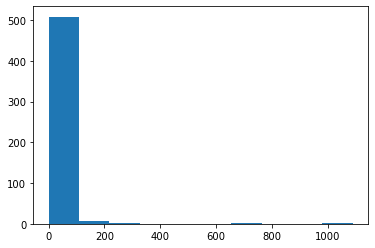

In [7]:
plt.hist(df.area) #Skewed response variable. log transform it

In [8]:
df.area = np.log1p(df.area)

In [9]:
df.describe()

,x,y,ffmc,dmc,dc,isi,temp,rh,wind,rain,area
count,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000
mean,4.669246,4.299807,90.644681,110.872340,547.940039,9.021663,18.889168,44.288201,4.017602,0.021663,1.111026
std,2.313778,1.229900,5.520111,64.046482,248.066192,4.559477,5.806625,16.317469,1.791653,0.295959,1.398436
min,1.000000,2.000000,18.700000,1.100000,7.900000,0.000000,2.200000,15.000000,0.400000,0.000000,0.000000
25%,3.000000,4.000000,90.200000,68.600000,437.700000,6.500000,15.500000,33.000000,2.700000,0.000000,0.000000
50%,4.000000,4.000000,91.600000,108.300000,664.200000,8.400000,19.300000,42.000000,4.000000,0.000000,0.418710
75%,7.000000,5.000000,92.900000,142.400000,713.900000,10.800000,22.800000,53.000000,4.900000,0.000000,2.024193
max,9.000000,9.000000,96.200000,291.300000,860.600000,56.100000,33.300000,100.000000,9.400000,6.400000,6.995620


### We now split dataset into train, test, val. This is so we can develop our model 

In [11]:
from sklearn.model_selection import train_test_split

In [12]:
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

In [ ]:
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

In [ ]:
y_train = df_train.area.values
y_val = df_val.area.values
y_test = df_test.area.values

In [ ]:
del df_train['area']
del df_val['area']
del df_test['area']

Now, use `DictVectorizer` to turn train and validation into matrices:

In [ ]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.feature_extraction import DictVectorizer

In [ ]:
train_dict = df_train.to_dict(orient='records')

In [ ]:
dv = DictVectorizer(sparse='False')
X_train = dv.fit_transform(train_dict)

In [ ]:
val_dicts = df_val.to_dict(orient='records')
X_val = dv.transform(val_dicts)

We intend to use 3 different tools to predict the burned area of forest fires, in the northeast region of Portugal

1. Decision Tree Regressor
2. Random Forest
3. XGBoost
Since our dataset follows a regression problem, RMSE will be used to estimate the prefered model. The lower the RMSE, the better.

 ## 1. Using Decision Tree Regressor

Using Decision Tree, 2 main parameters are of focus. `max_depth` and `min_sample_leaf`. We iterate over different values of these parameters to get our predictions.

In [ ]:
from sklearn.tree import export_text
from sklearn.metrics import mean_squared_error

In [ ]:
depths = [1, 2, 3, 5, 10, 15, 20, None]

for depth in depths:
    dt = DecisionTreeRegressor(max_depth=depth, random_state=1)
                               # min_samples_leaf=min_samples_leaf)
    dt.fit(X_train, y_train)
    
    y_pred = dt.predict(X_val)
    rmse = np.sqrt(mean_squared_error(y_val, y_pred))
    
    print('%4s -> %.3f' % (depth, rmse))
    
#Lowest rmse = depth of 1

In [ ]:
scores = []

for depth in [1, 2, 3]: #we chose the 3 lowest RMSE to estimate our prefered min_sample_leaf
    for s in [1, 5, 10, 15, 20, 50, 100]:
        dt = DecisionTreeRegressor(max_depth=depth, min_samples_leaf=s, random_state=1)
        dt.fit(X_train, y_train)

        y_pred = dt.predict(X_val)
        rmse = np.sqrt(mean_squared_error(y_val, y_pred))
        
        scores.append((depth, s, rmse))

In [ ]:
columns = ['max_depth', 'min_samples_leaf', 'rmse']
df_scores = pd.DataFrame(scores, columns=columns)

In [ ]:
df_scores_pivot = df_scores.pivot(index='min_samples_leaf', columns=['max_depth'], values=['rmse'])
df_scores_pivot.round(3)

In [ ]:
sns.heatmap(df_scores_pivot, annot=True, fmt=".3f")

The heatmap indicates that `max_depth` of 1  is the best with RMSE of 1.342 while `min_sample_leaf` can be any of the values. We decide to use a `min_sample_leaf` of 20. `min_sample_leaf` of 20 was randomly chosen since we had all to be similar.   
We then train our model on the validation dataset as expected using these parameters.

In [ ]:
dt = DecisionTreeRegressor(max_depth=1, min_samples_leaf=20, random_state=1)
dt.fit(X_train, y_train)

In [ ]:
y_pred = dt.predict(X_val)
np.sqrt(mean_squared_error(y_val, y_pred))

In [ ]:
y_pred = dt.predict(X_train)
np.sqrt(mean_squared_error(y_train, y_pred))

In [ ]:
print(export_text(dt, feature_names=dv.get_feature_names()))

## 2. Using Random Forest

Using Random Forest Regressor, 3 parameters are of focus. `n_estimator`, `max_depth` and `min_sample_leaf`. We iterate over different values of these parameters to get our predictions.

In [ ]:
from sklearn.ensemble import RandomForestRegressor

In [ ]:
scores = []

for d in [5, 10, 15]:
    for n in range(10, 201, 10):
        rf = RandomForestRegressor(n_estimators=n, max_depth=d,
                                    random_state=1)
        rf.fit(X_train, y_train)

        y_pred = rf.predict(X_val)
        rmse = np.sqrt(mean_squared_error(y_val, y_pred))

        scores.append((d, n, rmse))

columns = ['max_depth', 'n_estimators', 'rmse']
df_scores = pd.DataFrame(scores, columns=columns)

In [ ]:
for d in [5, 10, 15]:
    df_subset = df_scores[df_scores.max_depth == d]
    
    plt.plot(df_subset.n_estimators, df_subset.rmse,
             label='max_depth=%d' % d)

plt.xlabel('n_estimator')
plt.ylabel('r_mse')
plt.legend()

plt.ylim([1.32, 1.38])

A line plot shows us that a `max_depth` of 5 and `n_estimator` of about 70 produces the best RMSE, therefore it is preferred moving forward.

In [ ]:
RandomForestRegressor(n_estimators=70, max_depth=5, random_state=1) ##

In [ ]:
max_depth=5

In [ ]:
scores = []

for s in [1, 3, 5, 10, 50]:
    for n in range(10, 201, 10):
        rf = RandomForestRegressor(n_estimators=n,
                                    max_depth=max_depth,
                                    min_samples_leaf=s,
                                    random_state=1)
        rf.fit(X_train, y_train)

        y_pred = rf.predict(X_val)
        rmse = np.sqrt(mean_squared_error(y_val, y_pred))

        scores.append((s, n, rmse))

In [ ]:
columns = ['min_samples_leaf', 'n_estimators', 'rmse']
df_scores = pd.DataFrame(scores, columns=columns)

In [ ]:
colors = ['black', 'blue', 'orange', 'red', 'grey']
values = [1, 3, 5, 10, 50]

for s, col in zip(values, colors):
    df_subset = df_scores[df_scores.min_samples_leaf == s]
    
    plt.plot(df_subset.n_estimators, df_subset.rmse,
             color=col,
             label='min_samples_leaf=%d' % s)

plt.xlabel('n_estimators')
plt.ylabel('r_mse')
plt.legend()
plt.ylim([1.31, 1.35])

The line plot above suggests that a `min_sample_leaf` of 1 performs better. These 3 parameter estimates will then be used to predict our dataset. The RMSE from her performs slightly better than the Decision Tree algorithm. (`1.326 < 1.342`)

In [ ]:
rf = RandomForestRegressor(n_estimators=70, max_depth=5, min_samples_leaf=1, random_state=1)
rf.fit(X_train, y_train)

y_pred = rf.predict(X_val)
rmse = np.sqrt(mean_squared_error(y_val, y_pred))
rmse

While still analyzing with random forest regressor, we thought to check which features are most important in predicting forest fires in portugal.

In [ ]:
#rf.feature_importances_
df_importance = pd.DataFrame()
df_importance['features'] = dv.get_feature_names()
df_importance['importances'] = rf.feature_importances_

In [ ]:
df_importance.sort_values(by='importances', ascending=False).head(10)

The top 3 most importance features to predict portugal forest fires are;
1. temperature in Celsius degrees: 2.2 to 33.30 (th)
2. relative humidity in %: 15.0 to 100 (rh)
3. DMC index from the FWI system: 1.1 to 291.3 (dmc)

Wind is estimated to be the 6th most importance feature in forest fires.

## 3. Using Gradient Boosting; XgBoost

Using Gradient Boosting, we also focus on 3 parameters. The learning rate (`eta`), `max_depth` and `min_child_weight`. We iterate over different values of these parameters to get our predictions.

In [ ]:
import xgboost as xgb

In [ ]:
features = dv.get_feature_names()
dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=features)
dval = xgb.DMatrix(X_val, label=y_val, feature_names=features)

In [ ]:
#A watchlist was created so that we can see our output after running the xgboost function
watchlist = [(dtrain, 'train'), (dval, 'val')] 

In [ ]:
#This function allows us to wrangle the output generated from the xgboost function
def parse_xgb_output(output):
    results = []

    for line in output.stdout.strip().split('\n'):
        it_line, train_line, val_line = line.split('\t')

        it = int(it_line.strip('[]'))
        train = float(train_line.split(':')[1])
        val = float(val_line.split(':')[1])

        results.append((it, train, val))
    
    columns = ['num_iter', 'train_rmse', 'val_rmse']
    df_results = pd.DataFrame(results, columns=columns)
    return df_results

In [ ]:
#We create this dictionary inorder to save our multiple iterations of eta.
scores = {} 

**Note to self**: I am unable to write a function that allows me to iterate code below because of the magic funtion (`%%`) used in the cell.   
Several, values of `eta` (0.3, 0.1, 0.01) were used to find the best `eta` after which we then proceeded to find the prefered `max_depth` followed by the `min_child_weight`.

In [ ]:
%%capture output

xgb_params = {
    'eta': 0.3, #manually change "eta" for several values eg; 0.01, 0.1, 0.5, 1.0
    'max_depth': 6, #manually change "max_depth" for several values eg; 2, 4, 6, 7, 10
    'min_child_weight': 1, #manually change "min_child_weight" for several values eg; 1. 2. 5, 10
    
    'objective': 'reg:squarederror',
    # 'eval_metric': 'rmse',

    'nthread': 8,
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=200,
                  verbose_eval=5,
                  evals=watchlist)

In [ ]:
# df_score = parse_xgb_output(output)

In [ ]:
# key = 'eta=%s' % (xgb_params['eta'])
# scores[key] = parse_xgb_output(output)
# key

In [ ]:
s = output.stdout #just checking what output looks like
print(s[:200])

In [ ]:
scores['eta=0.3'] = parse_xgb_output(output)

In [ ]:
%%capture output

xgb_params = {
    'eta': 0.1, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'reg:squarederror',
    # 'eval_metric': 'rmse',

    'nthread': 8,
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=200,
                  verbose_eval=5,
                  evals=watchlist)

In [ ]:
scores['eta=0.1'] = parse_xgb_output(output)

In [ ]:
%%capture output

xgb_params = {
    'eta': 0.01, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'reg:squarederror',
    # 'eval_metric': 'rmse',

    'nthread': 8,
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=200,
                  verbose_eval=5,
                  evals=watchlist)

In [ ]:
scores['eta=0.01'] = parse_xgb_output(output)

In [ ]:
scores.keys()

In [ ]:
plt.plot(scores['eta=0.3']['num_iter'], scores['eta=0.3']['val_rmse'], label='0.3')
plt.plot(scores['eta=0.1']['num_iter'], scores['eta=0.1']['val_rmse'], label='0.1')
plt.plot(scores['eta=0.01']['num_iter'], scores['eta=0.01']['val_rmse'], label='0.01')

plt.ylim([1.35, 1.40])

plt.xlabel('num_boost_round')
plt.ylabel('Validation RMSE')
plt.title('Checking for best learning rate (ETA)')
plt.legend() 

#We choose rmse of 0.01. Much more stable than 0.1

In [ ]:
# scores = {}

In [ ]:
# eta = [0.3, 0.1, 0.01]

In [ ]:
# for rate in eta:

#     %%capture output ####****Magic function not working in for loop

#     xgb_params = {
#         'eta': rate, #manually change "eta" for several values eg; 0.01, 0.1, 0.5, 1.0
#         'max_depth': 6, ##manually change "max_depth" for several values eg; 2, 4, 6, 7, 10
#         'min_child_weight': 1, #manually change "min_hild_weight" for several values eg; 0.01, 0.1, 0.5, 1.0

#         'objective': 'reg:squarederror',
#         'eval_metric': 'rmse',

#         'nthread': 8,
#         'seed': 1,
#         'verbosity': 1,
#     }

#     model = xgb.train(xgb_params, dtrain, num_boost_round=200,
#                       verbose_eval=5,
#                       evals=watchlist)

#     key = 'eta=%s' % (xgb_params['eta'])
#     scores[key] = parse_xgb_output(output)
    
# #    parse_xgb_output(output)

### Find preferred depth. Choose between depths (1, 2, 3, 5, 10)

In [ ]:
depth = {}

In [ ]:
%%capture output

xgb_params = {
    'eta': 0.01, 
    'max_depth': 1, #manually change "max_depth" for several values eg; 1, 2, 3, 5, 10
    'min_child_weight': 1,
    
    'objective': 'reg:squarederror',
    # 'eval_metric': 'rmse',

    'nthread': 8,
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=200,
                  verbose_eval=5,
                  evals=watchlist)

In [ ]:
depth['depth=1'] = parse_xgb_output(output)

In [ ]:
%%capture output

xgb_params = {
    'eta': 0.01, 
    'max_depth': 2,
    'min_child_weight': 1,
    
    'objective': 'reg:squarederror',
    # 'eval_metric': 'rmse',

    'nthread': 8,
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=200,
                  verbose_eval=5,
                  evals=watchlist)

In [ ]:
depth['depth=2'] = parse_xgb_output(output)

In [ ]:
%%capture output

xgb_params = {
    'eta': 0.01, 
    'max_depth': 3,
    'min_child_weight': 1,
    
    'objective': 'reg:squarederror',
    # 'eval_metric': 'rmse',

    'nthread': 8,
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=200,
                  verbose_eval=5,
                  evals=watchlist)

In [ ]:
depth['depth=3'] = parse_xgb_output(output)

In [ ]:
%%capture output

xgb_params = {
    'eta': 0.01, 
    'max_depth': 5,
    'min_child_weight': 1,
    
    'objective': 'reg:squarederror',
    # 'eval_metric': 'rmse',

    'nthread': 8,
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=200,
                  verbose_eval=5,
                  evals=watchlist)

In [ ]:
depth['depth=5'] = parse_xgb_output(output)

In [ ]:
%%capture output

xgb_params = {
    'eta': 0.01, 
    'max_depth': 10,
    'min_child_weight': 1,
    
    'objective': 'reg:squarederror',
    # 'eval_metric': 'rmse',

    'nthread': 8,
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=200,
                  verbose_eval=5,
                  evals=watchlist)

In [ ]:
depth['depth=10'] = parse_xgb_output(output)

In [ ]:
depth.keys()

In [ ]:
plt.plot(depth['depth=1']['num_iter'], depth['depth=1']['val_rmse'], label='depth=1')
plt.plot(depth['depth=2']['num_iter'], depth['depth=2']['val_rmse'], label='depth=2')
plt.plot(depth['depth=3']['num_iter'], depth['depth=3']['val_rmse'], label='depth=3')
plt.plot(depth['depth=5']['num_iter'], depth['depth=5']['val_rmse'], label='depth=5')
plt.plot(depth['depth=10']['num_iter'], depth['depth=10']['val_rmse'], label='depth=10')

plt.ylim([1.30, 1.350])

plt.xlabel('num_boost_round')
plt.ylabel('Validation RMSE')
plt.title('Checking for best max_depth')
plt.legend() 

#We choose max_depth of 1

With an `eta` of 0.01, we observed that a `max_depth` of 1 produces the best RMSE. We then proceed to do similar with `min_child_weight`. We wont be doing this but will choose the default value of `1` and `n_estimator` of 150 .

In [ ]:
#Final xgboost paramters
xgb_params = {
    'eta': 0.01, 
    'max_depth': 1,
    'min_child_weight': 1,
    
    'objective': 'reg:squarederror',
    # 'eval_metric': 'rmse',

    'nthread': 8,
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=150)
#                   verbose_eval=5,
#                   evals=watchlist)

## Selecting the final model

We will be selecting our best model from the trio of `Decision Tree`, `Random Forest` and `xgboost`. Final models are below

1. Decision Tree

In [ ]:
dt = DecisionTreeRegressor(max_depth=1, min_samples_leaf=20)
dt.fit(X_train, y_train)

y_pred = dt.predict(X_val)
np.sqrt(mean_squared_error(y_val, y_pred))

2. Random Forest

In [ ]:
rf = RandomForestRegressor(n_estimators=70, max_depth=5, min_samples_leaf=1, random_state=1)
rf.fit(X_train, y_train)

y_pred = rf.predict(X_val)
rmse = np.sqrt(mean_squared_error(y_val, y_pred))
rmse

3. XGBoost

In [ ]:
xgb_params = {
    'eta': 0.01, 
    'max_depth': 1,
    'min_child_weight': 1,
    
    'objective': 'reg:squarederror',
    # 'eval_metric': 'rmse',

    'nthread': 8,
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=150)

In [ ]:
y_pred = model.predict(dval)
np.sqrt(mean_squared_error(y_val, y_pred))

Final model with the least RMSE is XGBoost with RMSE of `1.305`. We will then use this on the `df_full_train` dataset

In [ ]:
df_full_train.head()

In [ ]:
df_full_train = df_full_train.reset_index(drop=True)

In [ ]:
y_full_train = df_full_train.area.values

In [ ]:
del df_full_train['area']

In [ ]:
dicts_full_train = df_full_train.to_dict(orient='records')

dv = DictVectorizer(sparse=False)
X_full_train = dv.fit_transform(dicts_full_train)

In [ ]:
dicts_test = df_test.to_dict(orient='records')
X_test = dv.transform(dicts_test)

In [ ]:
dfulltrain = xgb.DMatrix(X_full_train, label=y_full_train,
                    feature_names=dv.get_feature_names())

dtest = xgb.DMatrix(X_test, feature_names=dv.get_feature_names())

In [ ]:
xgb_params = {
    'eta': 0.03, 
    'max_depth': 1,
    'min_child_weight': 1,

    'objective': 'reg:squarederror',
    
    'nthread': 8,
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dfulltrain, num_boost_round=150)

In [ ]:
y_pred = model.predict(dtest)
np.sqrt(mean_squared_error(y_test, y_pred))